In [2]:
import math
import json
import requests
import itertools
import numpy as np
import time
from datetime import datetime, timedelta
import pandas as pd

In [16]:

def ouro(post):
    a={
            'id': post['id'],
            'created_utc': post['created_utc'],
            'is_self': post['is_self'],
            'num_comments': post['num_comments'],
            'score': post['score'],
            'subreddit_subscribers': post['subreddit_subscribers'],
            'author': post['author'],
            'title': post['title'],
            
            
        }

    if 'gildings' in post.keys():
        a['gildings']=post['gildings']
    else:
        a['gildings']=0
    if 'link_flair_text' in post.keys():
        a['link_flair_text']=post['link_flair_text']
    else:
        a['link_flair_text']=''
        
    return a


def give_me_intervals(start_at, number_of_days_per_interval = 3):
    
    end_at = math.ceil(datetime.utcnow().timestamp())
        
    ## 1 day = 86400,
    period = (86400 * number_of_days_per_interval)

    end = start_at + period
    yield (int(start_at), int(end))

    padding = 1
    while end <= end_at:
        start_at = end + padding
        end = (start_at - padding) + period
        yield int(start_at), int(end)

def make_request(uri, max_retries = 5):
    def fire_away(uri):
        response = requests.get(uri)
        assert response.status_code == 200
        return json.loads(response.content)

    current_tries = 1
    while current_tries < max_retries:
        try:
            response = fire_away(uri)
            return response
        except:
            time.sleep(.150)
            current_tries += 1

    return fire_away(uri)
 
def pull_posts_for(subreddit, start_at, end_at):
    
    def map_posts(posts):
        return list(map(lambda post: ouro(post) , posts))
    
    SIZE = 500
    URI_TEMPLATE = r'https://api.pushshift.io/reddit/search/submission?subreddit={}&after={}&before={}&size={}'
    
    post_collections = map_posts( \
        make_request( \
            URI_TEMPLATE.format(subreddit, start_at, end_at, SIZE))['data'])

    n = len(post_collections)
    while n == SIZE:
        last = post_collections[-1]
        new_start_at = last['created_utc'] - 10
        
        more_posts = map_posts( \
            make_request( \
                URI_TEMPLATE.format(subreddit, new_start_at, end_at, SIZE))['data'])
        
        n = len(more_posts)
        post_collections.extend(more_posts)

    return post_collections

In [61]:
subreddit = 'Brasil'
for i in range(12):
    if i <8:
        datetime_obj = datetime.strptime(r'01/0' +str(i+2)+ r'/2019', r'%d/%m/%Y')
    elif i<11:
        datetime_obj = datetime.strptime(r'01/' +str(i+2)+ r'/2019', r'%d/%m/%Y')
    else:
        datetime_obj = datetime.strptime(r'01/0' +str(np.ceil((i+1)/12).astype(int))+ r'/2020', r'%d/%m/%Y')
    
    end_at = math.ceil(datetime_obj.timestamp())
    start_at = math.floor((datetime_obj - timedelta(days=31)).timestamp())
    posts = pull_posts_for(subreddit, start_at, end_at)

    print('found:', len(posts))
    print('unique:', len(np.unique([ post['id'] for post in posts ])))
    posts_df=pd.DataFrame(posts)
    posts_df['time']=pd.to_datetime(posts_df['created_utc'],unit='s')
    posts_df.to_csv('dados_rbrasil'+str(i)+'.csv')
    print('salvando ', i)
    time.sleep(2.150)

found: 5818
unique: 5807
salvando  11


Dando uma olhada em cada entrada

In [124]:
posts[1]


{'id': 'dc12vm',
 'created_utc': 1569969169,
 'is_self': False,
 'num_comments': 13,
 'score': 26,
 'subreddit_subscribers': 276401,
 'author': 'tharmsthegreat',
 'title': 'E aí galera, vamo roubar a ideia do Grafo e mandar uma mensagem pra nós mesmos, daqui um ano a gente vê o que aconteceu?'}

In [62]:
import os
posts_df=pd.DataFrame
files=os.listdir()
for i in files:
    if 'dados_rbrasil' in i:
        temp=pd.read_csv(i)
        if posts_df.empty:
            posts_df=temp
        else:
            posts_df=pd.concat((posts_df,temp),sort=True)
posts_df.drop_duplicates(subset='id',inplace=True)
posts_df.drop('Unnamed: 0',axis=1,inplace=True)

posts_df['time']=pd.to_datetime(posts_df['created_utc'],unit='s')

In [63]:
posts_df.shape


(83040, 11)

In [64]:
posts_df.sort_values(by='created_utc',inplace=True)
posts_df.set_index('time',inplace=True)


In [65]:
posts_df


,author,created_utc,gildings,id,is_self,link_flair_text,num_comments,score,subreddit_subscribers,title
time,,,,,,,,,,
2018-12-31 23:01:56,hugostoso_24,1546297316,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcax0,True,"Ei, /r/brasil...",5,1,205090,Mega sena
2018-12-31 23:03:15,yamamotoyamamoto,1546297395,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcbc4,True,NaN,78,1,205090,Não posso deixar o ano acabar sem dizer uma verdade verdadeira
2018-12-31 23:03:16,ImNotASuspectCat,1546297396,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcbcf,False,NaN,0,1,205090,Exclusivo: Policial sem autorização entra na Granja do Torto e expõe falha na segurança de Bolsonaro - O Antagonista
2018-12-31 23:03:59,ImNotASuspectCat,1546297439,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcbmf,False,NaN,3,1,205090,"Macaco bugio ataca criança de 1 ano em Ourinhos, interior de SP"
2018-12-31 23:05:26,ImNotASuspectCat,1546297526,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcc57,False,Política,0,1,205090,Izabella Camargo aceita convite para atuar no governo de Jair Bolsonaro - 31/12/2018 - UOL TV e Famosos
2018-12-31 23:06:27,ImNotASuspectCat,1546297587,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abccgo,False,Política,70,1,205090,"Temer não faz decreto, e salário mínimo fica em R$ 954 em vez de R$ 1.006 - 31/12/2018 - UOL Economia"
2018-12-31 23:08:28,MrAms1204,1546297708,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcd3w,False,NaN,25,1,205091,Just gonna leave this here
2018-12-31 23:13:15,yodavid1,1546297995,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcerz,True,Discussão,0,1,205094,"Meu pai nasceu em 1934 em tem 84 anos. Eu, em 84 e tenho 33. Coincidência??"
2018-12-31 23:17:11,Zipp3r1986,1546298231,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",abcg4v,True,Desabafo,25,1,205095,"Contrastando o colega, eu ODEIO natal e ano novo...."


C:\Users\Felipo Soares\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


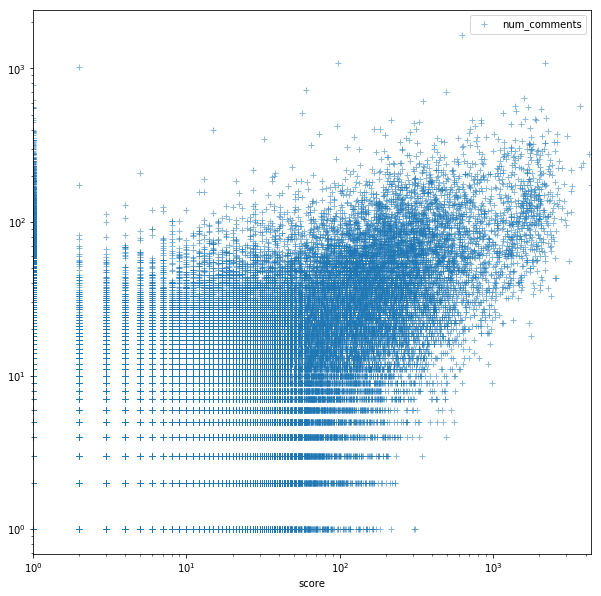

In [66]:
ax=posts_df.plot(x='score',y='num_comments',style='+',logx=True,logy=True,alpha=0.5,figsize=(10,10))
ax.set_ylabel='numero de comentarios'


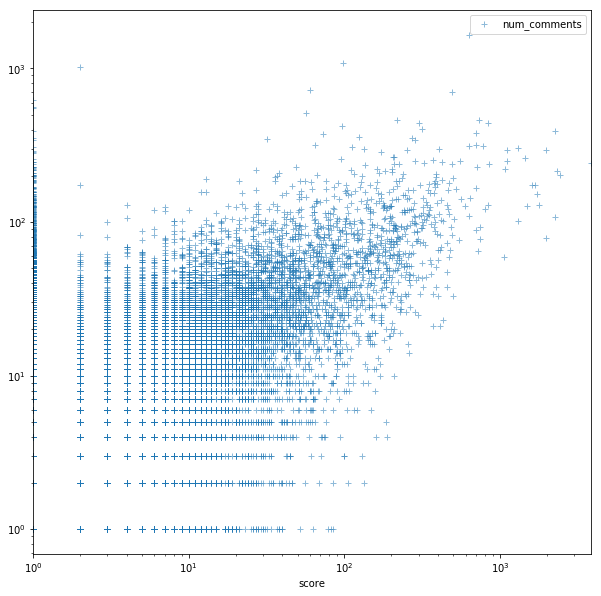

In [67]:
ax=posts_df.loc[posts_df['is_self']==True].plot(x='score',y='num_comments',style='+',logx=True,logy=True,alpha=0.5,figsize=(10,10))
ax.set_ylabel='numero de comentarios'


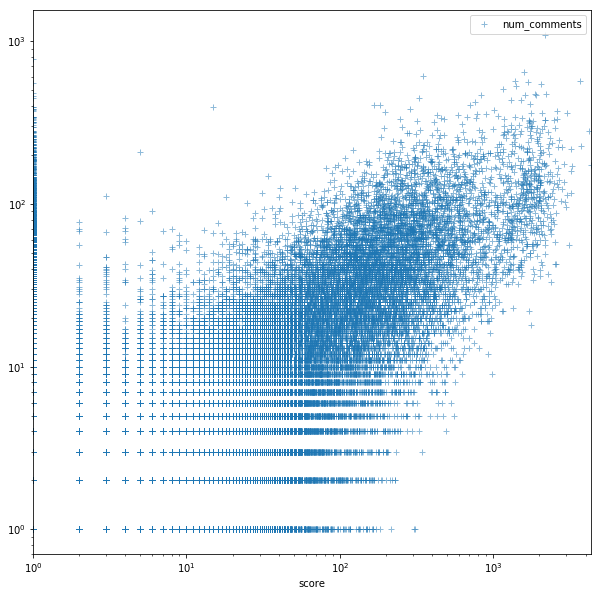

In [68]:
ax=posts_df.loc[posts_df['is_self']==False].plot(x='score',y='num_comments',style='+',logx=True,logy=True,alpha=0.5,figsize=(10,10))
ax.set_ylabel='numero de comentarios'


# Quer karma, não poste texto

In [98]:
print('media e mediana de votos para todos os posts')
bool_karma=np.logical_and(posts_df['created_utc']>1550269662,posts_df['created_utc']<1573120770)
print(posts_df.loc[bool_karma,'score'].mean())
print(posts_df.loc[bool_karma,'score'].median())
print('media e mediana de votos para posts self')

print(posts_df.loc[np.logical_and(bool_karma,posts_df['is_self']==True)]['score'].mean())
print(posts_df.loc[np.logical_and(bool_karma,posts_df['is_self']==True)]['score'].median())
print('media e mediana de votos para posts não self')
print(posts_df.loc[np.logical_and(bool_karma,posts_df['is_self']==False)]['score'].mean())
print(posts_df.loc[np.logical_and(bool_karma,posts_df['is_self']==False)]['score'].median())


media e mediana de votos para todos os posts
66.80466814232383
11.0
media e mediana de votos para posts self
19.438429609131788
4.0
media e mediana de votos para posts não self
85.82705130579737
18.0


# Poste texto se quiser conversa

In [71]:
print('media e mediana de num de comentario para todos os posts')
print(posts_df['num_comments'].mean())
print(posts_df['num_comments'].median())
print('media e mediana de num de comentario para posts self')
print(posts_df.loc[posts_df['is_self']==True]['num_comments'].mean())
print(posts_df.loc[posts_df['is_self']==True]['num_comments'].median())
print('media e mediana de num de comentario para posts nao self')
print(posts_df.loc[posts_df['is_self']==False]['num_comments'].mean())
print(posts_df.loc[posts_df['is_self']==False]['num_comments'].median())


media e mediana de num de comentario para todos os posts
15.834296724470136
6.0
media e mediana de num de comentario para posts self
16.764531776699826
8.0
media e mediana de num de comentario para posts nao self
15.448887829137854
5.0


# Apesar de um aumento de 50% no num de subscribers, não houve um aumento proporcional no numero de comentarios ou posts

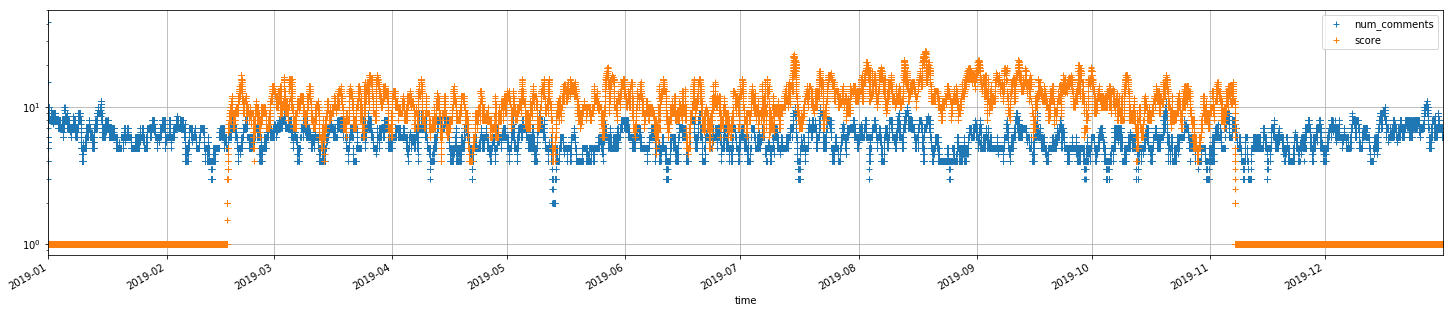

In [125]:
a=posts_df.loc[:,['num_comments','score']].rolling('1d', min_periods=1).median()
a.plot(figsize=(25,5),style='+',grid=True,logy=True)


antes de 15 de fevereiro e depois de 4 de novembro o pushshift nao registrou info de karma

# Posts notaveis

## Mais comentados

In [91]:
pd.options.display.max_colwidth=200
print(posts_df.sort_values(by='num_comments',inplace=False,ascending=False)[:10][['title','num_comments','score','id']])


                                                                                             title  \
time                                                                                                 
2019-03-13 13:58:29                                         MEGATHREAD - Ataque a Escola em Suzano   
2019-06-09 21:14:41  O Intercept está publicando os chats privados sobre a Lava Jato e Sérgio Moro   
2019-10-29 11:53:26                                                           Megathread ENEM 2019   
2019-04-01 21:51:20                                       Bugando o Auto Moderador nos comentários   
2019-11-08 19:22:02                     Juiz determina saída de Lula da prisão após decisão do STF   
2019-05-26 14:04:09                                       Megathread - protestos do dia 26 de Maio   
2019-03-21 14:27:01                                                       MEGATHREAD - Temer preso   
2019-10-13 17:41:47                                                    Forma moder

Todos nos sabemos como é passar por um topico, ver 10 de karma e 50 comentarios, e saber que é drama. Para isso criei a metrica treta

treta= num de comentarios/(karma+15)

O 15 épara evitar o excesso de topicos com 0 karma

In [96]:
posts_df['treta']=posts_df['num_comments']/(posts_df['score']+15)
print(posts_df.loc[np.logical_and(posts_df['created_utc']>1550269662,posts_df['created_utc']<1573120770)].sort_values(by='treta',inplace=False,ascending=False)[:10][['title','num_comments','treta','score','id']])


                                                                                  title  \
time                                                                                      
2019-04-01 21:51:20                            Bugando o Auto Moderador nos comentários   
2019-04-15 20:23:01     Novas regras envolvendo posts, imagens de redes sociais e memes   
2019-10-02 09:24:26                                       Alguém aqui é anti-feminista?   
2019-05-26 14:04:09                            Megathread - protestos do dia 26 de Maio   
2019-10-29 11:53:26                                                Megathread ENEM 2019   
2019-09-04 19:12:52                                     Eu desisto de ficar no r/brasil   
2019-07-08 16:02:09              Uma contradição fundamental no pensamento esquerdista.   
2019-07-07 23:22:08  Um familiar pediu uma pizza no meio do segundo tempo do jogo do Br   
2019-04-25 17:57:37                                    MEGATHREAD - VINGADORES ULTIMATO   

Adicionei mais 10 entradas, porque as anteriores tinham muitos posts fixados

In [97]:
print(posts_df.loc[np.logical_and(posts_df['created_utc']>1550269662,posts_df['created_utc']<1573120770)].sort_values(by='treta',inplace=False,ascending=False)[10:20][['title','num_comments','treta','score','id']])


                                                                                                                                                      title  \
time                                                                                                                                                          
2019-09-06 18:16:41                                                    Bolsonaro consegue unir todos! (que são manipulados a ponto de defender a corrupção)   
2019-03-28 14:01:49                                                                             Bate-Papo da Quinta - O que você está jogando? - 28.03.2019   
2019-10-10 14:01:03                                                                             Bate-Papo da Quinta - O que você está jogando? - 10.10.2019   
2019-11-03 13:15:30  Por que a galera fica atacando a Terra Plana e os Terra Planistas mas não atacam quem acredita em Horóscopo, ou na Bíblia por exemplo?   
2019-04-03 22:51:03                  Por que e

# Usuarios notaveis

## Usuarios que mais postam

In [101]:
posts_gb=posts_df.groupby(by='author')
author_counts=posts_df['author'].value_counts()
print(author_counts[:10])

HelloNOTW               1622
aangwasthebestavatar    1274
slimpedroca              986
CaPeBaLo                 852
Jvkas                    785
pepeperezcanyear         745
vitorgrs                 691
guy-in-doubt             587
ImNotASuspectCat         492
Who_Is_JohnGalt_2        465
Name: author, dtype: int64


Os melhores OP são aqueles com maior media de karma por post. A lista original de melhores OP são apenas pessoas que postaram uma vez. Então refiz a lista para os melhores OP que postam pelo menos uma vez ao mes.

In [110]:
best_author_mean=posts_gb.mean().loc[author_counts >=12 ,:].sort_values(by='score',ascending=False).loc[:,['score']][:10]
author_mean=posts_gb.mean().sort_values(by='score',ascending=False).loc[:,['score']]

print(best_author_mean)

                   score
author                  
Q1R0Z         513.333333
rbvilla90     430.240000
DudelinaBR    417.130435
rivaldowski   403.142857
fabinhobr     382.916667
antun3s       370.437500
herbertzilli  364.687500
vvarmbruster  351.545455
nesuno        344.333333
andr11n       342.870968


Autores que mais geraram karma ao sub

In [162]:
best_author_general=posts_gb.sum().sort_values(by='score',ascending=False).loc[:,['score']]
rows_tag=best_author_general.index[:10]
DF_print=pd.concat((best_author_general.loc[rows_tag,:],author_counts.loc[rows_tag],author_mean.loc[rows_tag]),axis=1)
DF_print.columns=['score total sum', 'total posts','mean score' ]
print(DF_print)

                      score total sum  total posts  mean score
author                                                        
aangwasthebestavatar            87624         1274   68.778650
slimpedroca                     81826          986   82.987830
pepeperezcanyear                52231          745   70.108725
TarmacWings                     48277          246  196.247967
yamamotoyamamoto                40971          293  139.832765
edu-fk                          35448          335  105.814925
kenkanoni                       33930          190  178.578947
d4n1l0v3                        30839          244  126.389344
Jvkas                           29740          785   37.885350
hirEfAcklEctaGenceaN            28757          146  196.965753
